In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from gurobipy import Model, GRB, Env
import math

pd.set_option('display.max_rows', 168)

In [2]:

df_best_results = pd.read_csv('../Data_folder/da_and_fake_pred.csv', sep=';')

df_btd = pd.read_csv('../Data_folder/btd_nec.csv', sep=';')



In [3]:
df_best_results['fake_pred'] = [round(i, 2) for i in df_best_results['fake_pred']]
df_best_results

,Unnamed: 0,timestamp,DA_price,datetime,fake_pred
0,0,1672527600,2.01,2023-01-01 00:00:00,2.10
1,1,1672531200,1.38,2023-01-01 01:00:00,1.35
2,2,1672534800,0.09,2023-01-01 02:00:00,0.07
3,3,1672538400,0.08,2023-01-01 03:00:00,0.08
4,4,1672542000,0.05,2023-01-01 04:00:00,0.06
...,...,...,...,...,...
8755,8755,1704045600,59.99,2023-12-31 19:00:00,59.03
8756,8756,1704049200,40.99,2023-12-31 20:00:00,40.36
8757,8757,1704052800,53.83,2023-12-31 21:00:00,54.38
8758,8758,1704056400,55.49,2023-12-31 22:00:00,53.47


# OPTIMIZATION ITSELF

In [4]:

## LICENSE NEEDED

license_options = {
    "WLSACCESSID": "",
    "WLSSECRET": "",
    "LICENSEID": ,
}


T_total = len(df_best_results) 
opt_window = 168  # Optimization window in hours - change based on how much we believe should be looked into
shift_period = 24  # Shift period for starting new optimization in hours
B_max = 53.1  # Max battery capacity in MWh
max_charge_discharge_rate = 26.5  # Max charge/discharge rate in MW - sets also the boundary for max MWh that can be dissipated
Eff= 0.95

E_a = 31500  # Activation energy in J/mol
R = 8.314  # Universal gas constant in J/(mol*K)
z = 0.552
E_rate = 53.1  # Rated capacity of the battery in MWh
T = 300  # Temperature in Kelvinz
C= 19e6
A = 330.330
Eff = 0.95

def Q_cycle(h, E_rate_joules, A, E_a, R, T, z):
    return A * np.exp(-E_a / (R * T)) * (h * E_rate_joules)**z

h_values_fraction = np.linspace(0.1, 1, 101)


Q_loss_mwh_values_per_MWh = [Q_cycle(h, E_rate, A, E_a, R, T, z)*(19e6/53.1) / (h*53.1) for h in h_values_fraction]

In [5]:
window_results = {}
initial_soc = 0.05 * B_max  # minimum of the battery
acc_profit = 0  # accumulated profit 

env = Env(params=license_options)

env.start()

for window_start in range(00, T_total, shift_period):
    end_hour = min(window_start + opt_window, T_total)  # Ensure we don't exceed the dataset
    
    P_price = df_best_results['fake_pred'].iloc[window_start:end_hour].tolist()
    P_true = df_best_results['DA_price'].iloc[window_start:end_hour].tolist()
    
    m = Model()
    m.Params.LogToConsole = 0

    Charge = m.addVars(range(opt_window), lb=0, ub=max_charge_discharge_rate, name="Charge")
    Discharge = m.addVars(range(opt_window), lb=0, ub=max_charge_discharge_rate, name="Discharge")
    StateOfCharge = m.addVars(range(opt_window), lb=0.05 * B_max, ub=0.95 * B_max, name="StateOfCharge")
    
      
    has_discharged = m.addVar(vtype=GRB.BINARY, name="has_discharged")
    
    m.addConstr(has_discharged * max_charge_discharge_rate * opt_window >= sum(Discharge[t] for t in range(min(opt_window, len(P_price)))), 
                name="link_has_discharged")

    m.setObjective(
        sum((Discharge[t] * Eff * (P_price[t] - Q_loss_mwh_values_per_MWh[math.floor(26.5/B_max *100)]) 
        - Charge[t] * P_price[t])
            for t in range(min(opt_window, len(P_price)))),
        GRB.MAXIMIZE
    )

    # Initial SoC constraint
    m.addConstr(StateOfCharge[0] == initial_soc, name="InitialSOC")

    # The initial discharge constraint
    m.addConstr(Discharge[0] <= initial_soc - 0.05 * B_max, name="DischargeLimitAtT0")
    
    # SoC constraints
    for t in range(0, min(opt_window, len(P_price))):
        if t == 0:
            m.addConstr(StateOfCharge[t] == initial_soc - Discharge[t] + Charge[t] * Eff, name=f"SOC_{t}")
        else:
            m.addConstr(StateOfCharge[t] == StateOfCharge[t-1] - Discharge[t] + Charge[t] * Eff, name=f"SOC_{t}")

    
    m.optimize()
    
    # Update initial_soc for the next optimization window
    if m.status == GRB.OPTIMAL:
        soc_at_shift_end = min(23, end_hour - window_start - 1)  # Ensure we don't go beyond the current window
        initial_soc = StateOfCharge[soc_at_shift_end].X
    
    if m.status == GRB.OPTIMAL:
        hourly_profits = [(Discharge[t].X * Eff - Charge[t].X) * P_true[t] - 
                          float(Discharge[t].X) * Q_loss_mwh_values_per_MWh[math.floor(Discharge[t].X/B_max *100)] 
                          for t in range(min(opt_window, len(P_price)))]

        P_trues = [P_true[t] for t in range(min(opt_window, len(P_price)))]
        acc_profits = [sum(hourly_profits[:t+1]) + acc_profit for t in range(len(hourly_profits))]
        acc_profit = acc_profits[23]  # Updating the accumulated profit - we use the profit at index 23, as that is hour 24
        data = {
            "Hour": list(range(window_start, window_start + len(hourly_profits))),
            "Charge (MWh)": [Charge[t].X for t in range(min(opt_window, len(P_price)))],
            "Discharge (MWh)": [Discharge[t].X for t in range(min(opt_window, len(P_price)))],
            "State of Charge (MWh)": [StateOfCharge[t].X for t in range(min(opt_window, len(P_price)))],
            "Price predicted" : P_price,
            "Price (CurrencyUnit)": P_true,
            "Accumulated Profit (CurrencyUnit)": acc_profits,
        }
        window_df = pd.DataFrame(data)
        window_results[f"Window_{window_start}"] = window_df




Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2478922
Academic license 2478922 - for non-commercial use only - registered to ol___@ut.ee
Restricted license - for non-production use only - expires 2025-11-24


In [6]:

df_list = []

sorted_keys = sorted(window_results.keys(), key=lambda x: int(x.split("_")[1]))

for key in sorted_keys:
    df = window_results[key]
    df_list.append(df)

concatenated_df = pd.concat(df_list)

final_df_mock = concatenated_df.drop_duplicates(subset=['Hour'], keep='last')

final_df_mock.reset_index(drop=True, inplace=True)

final_df_mock.tail(10)


,Hour,Charge (MWh),Discharge (MWh),State of Charge (MWh),Price predicted,Price (CurrencyUnit),Accumulated Profit (CurrencyUnit)
8750,8750,0.0,0.000000e+00,29.155,102.37,110.01,509281.176106
8751,8751,0.0,2.650000e+01,2.655,121.95,117.51,509960.707407
8752,8752,0.0,8.881784e-16,2.655,104.49,108.49,509960.707407
8753,8753,0.0,0.000000e+00,2.655,86.17,98.95,509960.707407
8754,8754,0.0,0.000000e+00,2.655,99.53,97.62,509960.707407
8755,8755,0.0,0.000000e+00,2.655,59.03,59.99,509960.707407
8756,8756,0.0,0.000000e+00,2.655,40.36,40.99,509960.707407
8757,8757,0.0,0.000000e+00,2.655,54.38,53.83,509960.707407
8758,8758,0.0,0.000000e+00,2.655,53.47,55.49,509960.707407
8759,8759,0.0,0.000000e+00,2.655,43.53,40.01,509960.707407


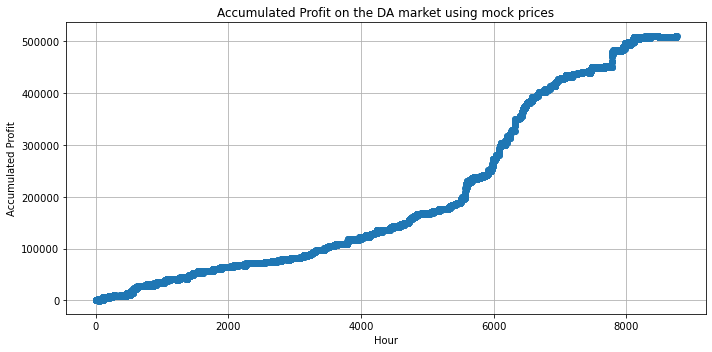

In [7]:


plt.figure(figsize=(10, 5))
plt.plot(final_df_mock['Hour'], final_df_mock['Accumulated Profit (CurrencyUnit)'], '-o')
plt.title('Accumulated Profit on the DA market using mock prices')
plt.xlabel('Hour')
plt.ylabel('Accumulated Profit')
plt.grid(True)
plt.tight_layout()

plt.show()


In [8]:
window_results_real = {}
initial_soc = 0.05 * B_max  # minimum of the battery
acc_profit = 0  # accumulated profit 

env = Env(params=license_options)

env.start()

for window_start in range(00, T_total, shift_period):
    end_hour = min(window_start + opt_window, T_total)
    
    P_price = df_best_results['DA_price'].iloc[window_start:end_hour].tolist()
    P_true = df_best_results['DA_price'].iloc[window_start:end_hour].tolist()
    
    m = Model()
    m.Params.LogToConsole = 0

    Charge = m.addVars(range(opt_window), lb=0, ub=max_charge_discharge_rate, name="Charge")
    Discharge = m.addVars(range(opt_window), lb=0, ub=max_charge_discharge_rate, name="Discharge")
    StateOfCharge = m.addVars(range(opt_window), lb=0.05 * B_max, ub=0.95 * B_max, name="StateOfCharge")
    
      
    has_discharged = m.addVar(vtype=GRB.BINARY, name="has_discharged")
    
    m.addConstr(has_discharged * max_charge_discharge_rate * opt_window >= sum(Discharge[t] for t in range(min(opt_window, len(P_price)))), 
                name="link_has_discharged")
    
    m.setObjective(
        sum((Discharge[t] * Eff * (P_price[t] - Q_loss_mwh_values_per_MWh[math.floor(26.5/B_max *100)]) 
        - Charge[t] * P_price[t])
            for t in range(min(opt_window, len(P_price)))),
        GRB.MAXIMIZE
    )

    m.addConstr(StateOfCharge[0] == initial_soc, name="InitialSOC")

    m.addConstr(Discharge[0] <= initial_soc - 0.05 * B_max, name="DischargeLimitAtT0")
    
    for t in range(0, min(opt_window, len(P_price))):
        if t == 0:
            m.addConstr(StateOfCharge[t] == initial_soc - Discharge[t] + Charge[t] * Eff, name=f"SOC_{t}")
        else:
            m.addConstr(StateOfCharge[t] == StateOfCharge[t-1] - Discharge[t] + Charge[t] * Eff, name=f"SOC_{t}")

    
    m.optimize()
    
    if m.status == GRB.OPTIMAL:
        soc_at_shift_end = min(23, end_hour - window_start - 1) 
        initial_soc = StateOfCharge[soc_at_shift_end].X
    
    if m.status == GRB.OPTIMAL:
        hourly_profits = [(Discharge[t].X * Eff - Charge[t].X) * P_true[t] - 
                          float(Discharge[t].X) * Q_loss_mwh_values_per_MWh[math.floor(Discharge[t].X/B_max *100)] 
                          for t in range(min(opt_window, len(P_price)))]
        acc_profits = [sum(hourly_profits[:t+1]) + acc_profit for t in range(len(hourly_profits))]
        acc_profit = acc_profits[23]  # Updating the accumulated profit - we use the profit at index 23, as that is hour 24
        data = {
            "Hour": list(range(window_start, window_start + len(hourly_profits))),
            "Charge (MWh)": [Charge[t].X for t in range(min(opt_window, len(P_price)))],
            "Discharge (MWh)": [Discharge[t].X for t in range(min(opt_window, len(P_price)))],
            "State of Charge (MWh)": [StateOfCharge[t].X for t in range(min(opt_window, len(P_price)))],
            "Price (CurrencyUnit)": P_price,
            "Accumulated Profit (CurrencyUnit)": acc_profits,
        }
        window_df = pd.DataFrame(data)
        window_results_real[f"Window_{window_start}"] = window_df

df_list = []

sorted_keys_real = sorted(window_results_real.keys(), key=lambda x: int(x.split("_")[1]))

for key in sorted_keys_real:
    df = window_results_real[key]
    df_list.append(df)

concatenated_df = pd.concat(df_list)

final_df_real = concatenated_df.drop_duplicates(subset=['Hour'], keep='last')

final_df_real.reset_index(drop=True, inplace=True)

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2478922
Academic license 2478922 - for non-commercial use only - registered to ol___@ut.ee


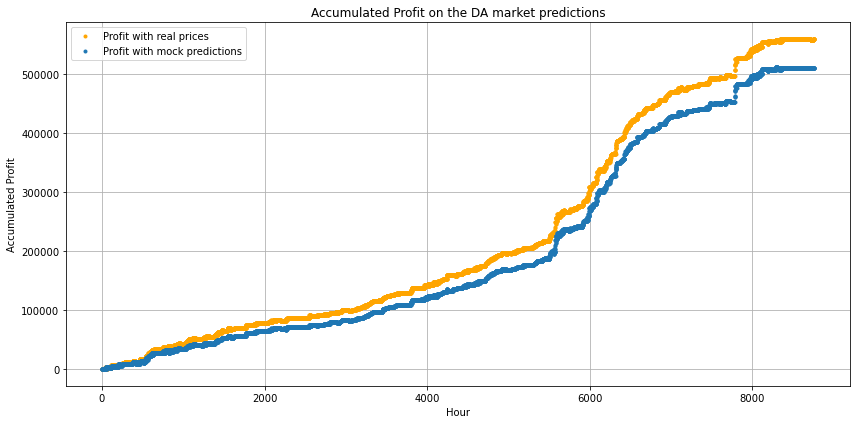

In [9]:


plt.figure(figsize=(12, 6))
plt.plot(final_df_real['Hour'], final_df_real['Accumulated Profit (CurrencyUnit)'], '.', label='Profit with real prices', color='orange')
plt.plot(final_df_mock['Hour'], final_df_mock['Accumulated Profit (CurrencyUnit)'], '.', label='Profit with mock predictions')
plt.title('Accumulated Profit on the DA market predictions')
plt.xlabel('Hour')
plt.ylabel('Accumulated Profit')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.savefig('da_real_and_mock.pdf')

plt.show()

In [10]:

def summarize_df(df, price_type):
    summary = {
        'Prices used': price_type,
        'Total Profit (€)': round(df['Accumulated Profit (CurrencyUnit)'].iloc[-1], 2),
        'Total sold on the DA market (MWh)': round(df['Discharge (MWh)'].sum()),
        'Total bought from the market (MWh)': round(df['Charge (MWh)'].sum())
    }
    if price_type == 'mock':
        summary['Mean Price for Charging (€/MWh)'] = round(df.loc[df['Charge (MWh)'] > 0, 'Price (CurrencyUnit)'].mean(), 2)
        summary['Mean Price for Discharging (€/MWh)'] = round(df.loc[df['Discharge (MWh)'] > 0, 'Price (CurrencyUnit)'].mean(), 2)
    else:  # real
        summary['Mean Price for Charging (€/MWh)'] = round(df.loc[df['Charge (MWh)'] > 0, 'Price (CurrencyUnit)'].mean(), 2)
        summary['Mean Price for Discharging (€/MWh)'] = round(df.loc[df['Discharge (MWh)'] > 0, 'Price (CurrencyUnit)'].mean(), 2)
    return summary

summary_real = summarize_df(final_df_real, 'real')
summary_mock = summarize_df(final_df_mock, 'mock')

comparative_df = pd.DataFrame([summary_real, summary_mock])

comparative_df


,Prices used,Total Profit (€),Total sold on the DA market (MWh),Total bought from the market (MWh),Mean Price for Charging (€/MWh),Mean Price for Discharging (€/MWh)
0,real,558847.43,11419,12020,36.72,181.14
1,mock,509960.71,12138,12777,40.84,177.16
